***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [5]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from xgboost import XGBClassifier
from xgboost import plot_importance

In [6]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [7]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

### HTML Read Data

In [8]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

#### Dropping constants

col_no_unique=[]
for col in df_html.columns[:-1]:
    if len(df_html[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df_html.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_html.shape)

#### 95% same values

lst=[]
for col in df_html.columns[:-1]:
    lst.append([col,dict(df_html[col].value_counts()),df_html[col].value_counts().values[0]>=len(df_html)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

df_html.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_html.shape)

#### Dropping columns based on high VIF values

rem=['a_href_absolute','a_href_relative','a_count','a_href_out_of_domain',
     'base_count','base_href_absolute','base_href_out_of_domain',
     'iframe_src_absolute','iframe_src_relative','iframe_sandbox_allow_same_origin_count','iframe_src_http',
     'img_src_absolute','img_src_http','img_srcset_absolute','img_src_relative','img_srcset_relative','img_count',
     'script_src_absolute','script_src_http','script_src_relative','script_count','script_src_https',
     'link_rel_wlwmanifest','link_href_absolute','link_href_relative','link_rel_EditURI','link_count',
     'link_type_application/wlwmanifest+xml','link_href_https','link_rel_stylesheet','link_href_.png',
     'form_action_absolute','form_action_relative','form_count','form_action_https',
     'form_enctype_application/x-www-form-urlencoded',
     'tbody_count',
     'nofollow_count']

print('{} columns are dropped because of high VIF values'.format(len(rem)))
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset after dropping them:",df_html.shape)

Shape of HTML dataset: (43491, 1461)
0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1461)
1297 columns have more than 95% same values
Shape of our dataset after dropping them: (43491, 164)
38 columns are dropped because of high VIF values
Shape of our dataset after dropping them: (43491, 126)


### JavaScript read data

In [9]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)

df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)

#### Dropping constants

col_no_unique=[]
for col in df_js.columns[:-1]:
    if len(df_js[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df_js.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_js.shape)

#### 95% same values

lst=[]
for col in df_js.columns[:-1]:
    lst.append([col,dict(df_js[col].value_counts()),df_js[col].value_counts().values[0]>=len(df_js)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst


print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

df_js.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_js.shape)


#### Dropping columns based on high VIF values

rem=['js_function_.defineProperty(','js_function_.keys(','js_function_.substr','js_function_unescape(','js_function_.log(']

print('{} columns are dropped because of high VIF values'.format(len(rem)))
df_js.drop(rem,axis=1,inplace=True)
print("Shape of our dataset after dropping them:",df_js.shape)

113 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43294, 288)
234 columns have more than 95% same values
Shape of our dataset after dropping them: (43294, 54)
5 columns are dropped because of high VIF values
Shape of our dataset after dropping them: (43294, 49)


In [10]:
df=pd.concat([df_js,df_html],axis=1,join='inner')
df['Target_z']=df[['Target','Target']].apply(max,axis=1)
df.drop(['Target','Target'],axis=1,inplace=True)
df.rename(columns={'Target_z':'Target'},inplace=True)

In [11]:
df_sel=df.copy(deep=True)

In [14]:
X=df_sel.iloc[:,df_sel.columns!='Target']
Y=df_sel.Target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(model.feature_importances_)

# for thresh in thresholds:
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
#     selection_model = XGBClassifier(random_state=0)
#     selection_model.fit(select_X_train, y_train)
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_test)
#     predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_test, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 90.50%


In [15]:
# select features using threshold
selection = SelectFromModel(model, threshold=0.010, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier(random_state=0)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

selection_model = selection.get_support()
embeded_rf_feature = X.loc[:,selection_model].columns.tolist()

In [16]:
embeded_rf_feature.append('Target')
embeded_rf_feature

['dom_function_document.getElementById(',
 'dom_function_window.addEventListener(',
 'js_function_.find(',
 'js_function_.get(',
 'js_function_.indexOf(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_escape(',
 'a_href_.com',
 'a_href_http',
 'a_href_https',
 'br_count',
 'center_count',
 'div_count',
 'form_action_http',
 'img_src_.jpg',
 'img_src_out_of_domain',
 'li_count',
 'link_href_.css',
 'link_href_http',
 'link_href_out_of_domain',
 'link_rel_https://api.w.org/',
 'link_rel_shortlink',
 'link_type_application/rsd+xml',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'script_src_.js',
 'script_src_out_of_domain',
 'section_count',
 'span_count',
 'strong_count',
 'title_count',
 'Target']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [17]:
fin_col=embeded_rf_feature

df_sel=df_sel[fin_col]

In [18]:
train=df_sel.iloc[:28496,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel[fin_col].iloc[28496:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [19]:
columns=fin_col
columns.remove('Target')

In [20]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9133211678832117
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22288  2052    24340
True         418  3738     4156
__all__    22706  5790    28496

Accuracy of the model for test data is: 0.905756161467289
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9494   944    10438
True         207  1568     1775
__all__     9701  2512    12213



Logistic Regression
Accuracy of the model for training data is: 0.8938798427849522
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22243  2097    24340
True         927  3229     4156
__all__    23170  5326    28496

Accuracy of the model for test data is: 0.8944567264390404
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9517   921    10438
True         368  1407     1775
__all__     9885  2328    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9251824817518248
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22371  1969    24340
True         163  3993     4156
__all__    22534  5962    28496

Accuracy of the model for test data is: 0.910587079341685
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9542   896    10438
True         196  1579     1775
__all__     9738  2475    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.8995297585626053
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22197  2143    24340
True         720  3436     4156
__all__    22917  5579    28496

Accuracy of the model for test data is: 0.9001883239171374
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9496   942    10438
True         277  1498     1775
__all__     9773  2440    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9096364402021336
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22340  2000    24340
True         575  3581     4156
__all__    22915  5581    28496

Accuracy of the model for test data is: 0.9064930811430443
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9540   898    10438
True         244  1531     1775
__all__     9784  2429    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.9273933183604717
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22377  1963    24340
True         106  4050     4156
__all__    22483  6013    28496

Accuracy of the model for test data is: 0.9111602390894948
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9541   897    10438
True         188  1587     1775
__all__     9729  2484    12213



Bagging Classifier
Accuracy of the model for training data is: 0.925042111173498
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22370  1970    24340
True         166  3990     4156
__all__    22536  5960    28496

Accuracy of the model for test data is: 0.909768279701957
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9528   910    10438
True         192  1583     1775
__all__     9720  2493    12213



Neural Network-1
The accuracy of the model on training data is: 0.91328607523863


Predicted  False  True  __all__
Actual                         
False      22243  2097    24340
True         374  3782     4156
__all__    22617  5879    28496

The accuracy of the model on test data is: 0.9029722426922132


Predicted  False  True  __all__
Actual                         
False       9474   964    10438
True         221  1554     1775
__all__     9695  2518    12213

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [21]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [22]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.913321,3738.0,22288.0,2052.0,418.0,0.084306,0.100577
LogisticRegression,0.893880,3229.0,22243.0,2097.0,927.0,0.086154,0.223051
RandomForestClassifier,0.925182,3993.0,22371.0,1969.0,163.0,0.080896,0.039220
AdaBoostClassifier,0.899530,3436.0,22197.0,2143.0,720.0,0.088044,0.173244
GradientBoostingClassifier,0.909636,3581.0,22340.0,2000.0,575.0,0.082169,0.138354
ExtraTreeClassifier,0.927393,4050.0,22377.0,1963.0,106.0,0.080649,0.025505
BaggingClassifier,0.925042,3990.0,22370.0,1970.0,166.0,0.080937,0.039942
Neural Network-1,0.913286,3782.0,22243.0,2097.0,374.0,0.086154,0.089990


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.905756,1568.0,9494.0,944.0,207.0,0.090439,0.116620,0.896471,0.691402
LogisticRegression,0.894457,1407.0,9517.0,921.0,368.0,0.088235,0.207324,0.852220,0.632081
RandomForestClassifier,0.910587,1579.0,9542.0,896.0,196.0,0.085840,0.110423,0.901869,0.704692
AdaBoostClassifier,0.900188,1498.0,9496.0,942.0,277.0,0.090247,0.156056,0.876848,0.664348
GradientBoostingClassifier,0.906493,1531.0,9540.0,898.0,244.0,0.086032,0.137465,0.888252,0.685613
ExtraTreeClassifier,0.911160,1587.0,9541.0,897.0,188.0,0.085936,0.105915,0.904074,0.707602
BaggingClassifier,0.909768,1583.0,9528.0,910.0,192.0,0.087181,0.108169,0.902325,0.703591
Neural Network-1,0.902972,1554.0,9474.0,964.0,221.0,0.092355,0.124507,0.891569,0.682251


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [23]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [24]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

In [25]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.933278553820871
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      21677   2663    24340
True         585  23755    24340
__all__    22262  26418    48680

Accuracy of the model for test data is: 0.8802914926717432
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9124  1314    10438
True         148  1627     1775
__all__     9272  2941    12213



Logistic Regression
Accuracy of the model for training data is: 0.8932826622843056
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      20223   4117    24340
True        1078  23262    24340
__all__    21301  27379    48680

Accuracy of the model for test data is: 0.8508147056415295
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       8708  1730    10438
True          92  1683     1775
__all__     8800  3413    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9525267050123254
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22305   2035    24340
True         276  24064    24340
__all__    22581  26099    48680

Accuracy of the model for test data is: 0.910177679521821
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9506   932    10438
True         165  1610     1775
__all__     9671  2542    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.9080115036976171
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      20913   3427    24340
True        1051  23289    24340
__all__    21964  26716    48680

Accuracy of the model for test data is: 0.8725128960943257
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9002  1436    10438
True         121  1654     1775
__all__     9123  3090    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9230895645028759
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      21357   2983    24340
True         761  23579    24340
__all__    22118  26562    48680

Accuracy of the model for test data is: 0.8855318103660035
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9177  1261    10438
True         137  1638     1775
__all__     9314  2899    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.9533483976992605
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22309   2031    24340
True         240  24100    24340
__all__    22549  26131    48680

Accuracy of the model for test data is: 0.9098501596659297
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9502   936    10438
True         165  1610     1775
__all__     9667  2546    12213



Bagging Classifier
Accuracy of the model for training data is: 0.9524856203779787
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22306   2034    24340
True         279  24061    24340
__all__    22585  26095    48680

Accuracy of the model for test data is: 0.9087038401703104
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9483   955    10438
True         160  1615     1775
__all__     9643  2570    12213



Neural Network-1
The accuracy of the model on training data is: 0.9378389482333607


Predicted  False   True  __all__
Actual                          
False      21726   2614    24340
True         412  23928    24340
__all__    22138  26542    48680

The accuracy of the model on test data is: 0.8896258085646442


Predicted  False  True  __all__
Actual                         
False       9222  1216    10438
True         132  1643     1775
__all__     9354  2859    12213

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [26]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [27]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.933279,23755.0,21677.0,2663.0,585.0,0.109408,0.024035
LogisticRegression,0.893283,23262.0,20223.0,4117.0,1078.0,0.169145,0.044289
RandomForestClassifier,0.952527,24064.0,22305.0,2035.0,276.0,0.083607,0.011339
AdaBoostClassifier,0.908012,23289.0,20913.0,3427.0,1051.0,0.140797,0.043180
GradientBoostingClassifier,0.923090,23579.0,21357.0,2983.0,761.0,0.122555,0.031265
ExtraTreeClassifier,0.953348,24100.0,22309.0,2031.0,240.0,0.083443,0.009860
BaggingClassifier,0.952486,24061.0,22306.0,2034.0,279.0,0.083566,0.011463
Neural Network-1,0.937839,23928.0,21726.0,2614.0,412.0,0.107395,0.016927


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.880291,1627.0,9124.0,1314.0,148.0,0.125886,0.083380,0.895367,0.651784
LogisticRegression,0.850815,1683.0,8708.0,1730.0,92.0,0.165741,0.051831,0.891214,0.614530
RandomForestClassifier,0.910178,1610.0,9506.0,932.0,165.0,0.089289,0.092958,0.908877,0.709915
AdaBoostClassifier,0.872513,1654.0,9002.0,1436.0,121.0,0.137574,0.068169,0.897128,0.643903
GradientBoostingClassifier,0.885532,1638.0,9177.0,1261.0,137.0,0.120809,0.077183,0.901004,0.664346
ExtraTreeClassifier,0.909850,1610.0,9502.0,936.0,165.0,0.089672,0.092958,0.908685,0.709172
BaggingClassifier,0.908704,1615.0,9483.0,955.0,160.0,0.091493,0.090141,0.909183,0.707592
Neural Network-1,0.889626,1643.0,9222.0,1216.0,132.0,0.116497,0.074366,0.904568,0.673479


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [28]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [29]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

Shape after undersampling (8312, 34)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.5738691049085659
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4018   138     4156
True        3404   752     4156
__all__     7422   890     8312

Accuracy of the model for test data is: 0.8327192336035372
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9882   556    10438
True        1487   288     1775
__all__    11369   844    12213



Logistic Regression
Accuracy of the model for training data is: 0.8845043310875842
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3372   784     4156
True         176  3980     4156
__all__     3548  4764     8312

Accuracy of the model for test data is: 0.8357487922705314
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       8508  1930    10438
True          76  1699     1775
__all__     8584  3629    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9493503368623677
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3819   337     4156
True          84  4072     4156
__all__     3903  4409     8312

Accuracy of the model for test data is: 0.8978138049619259
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9332  1106    10438
True         142  1633     1775
__all__     9474  2739    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.8948508180943214
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3512   644     4156
True         230  3926     4156
__all__     3742  4570     8312

Accuracy of the model for test data is: 0.8614591009579956
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       8842  1596    10438
True          96  1679     1775
__all__     8938  3275    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9130173243503369
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3627   529     4156
True         194  3962     4156
__all__     3821  4491     8312

Accuracy of the model for test data is: 0.8766887742569394
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9042  1396    10438
True         110  1665     1775
__all__     9152  3061    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.9534408084696824
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3823   333     4156
True          54  4102     4156
__all__     3877  4435     8312

Accuracy of the model for test data is: 0.9020715630885122
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9382  1056    10438
True         140  1635     1775
__all__     9522  2691    12213



Bagging Classifier
Accuracy of the model for training data is: 0.9500721847930702
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3819   337     4156
True          78  4078     4156
__all__     3897  4415     8312

Accuracy of the model for test data is: 0.8960943257184967
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9294  1144    10438
True         125  1650     1775
__all__     9419  2794    12213



Neural Network-1
The accuracy of the model on training data is: 0.9227622713574546


Predicted  False  True  __all__
Actual                         
False       3598   558     4156
True          84  4072     4156
__all__     3682  4630     8312

The accuracy of the model on test data is: 0.8631785802014247


Predicted  False  True  __all__
Actual                         
False       8853  1585    10438
True          86  1689     1775
__all__     8939  3274    12213

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [30]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [31]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.573869,752.0,4018.0,138.0,3404.0,0.033205,0.819057
LogisticRegression,0.884504,3980.0,3372.0,784.0,176.0,0.188643,0.042348
RandomForestClassifier,0.949350,4072.0,3819.0,337.0,84.0,0.081088,0.020212
AdaBoostClassifier,0.894851,3926.0,3512.0,644.0,230.0,0.154957,0.055342
GradientBoostingClassifier,0.913017,3962.0,3627.0,529.0,194.0,0.127286,0.046679
ExtraTreeClassifier,0.953441,4102.0,3823.0,333.0,54.0,0.080125,0.012993
BaggingClassifier,0.950072,4078.0,3819.0,337.0,78.0,0.081088,0.018768
Neural Network-1,0.922762,4072.0,3598.0,558.0,84.0,0.134264,0.020212


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.832719,288.0,9882.0,556.0,1487.0,0.053267,0.837746,0.554493,0.151443
LogisticRegression,0.835749,1699.0,8508.0,1930.0,76.0,0.184901,0.042817,0.886141,0.595587
RandomForestClassifier,0.897814,1633.0,9332.0,1106.0,142.0,0.105959,0.080000,0.907021,0.687846
AdaBoostClassifier,0.861459,1679.0,8842.0,1596.0,96.0,0.152903,0.054085,0.896506,0.630902
GradientBoostingClassifier,0.876689,1665.0,9042.0,1396.0,110.0,0.133742,0.061972,0.902143,0.654077
ExtraTreeClassifier,0.902072,1635.0,9382.0,1056.0,140.0,0.101169,0.078873,0.909979,0.697234
BaggingClassifier,0.896094,1650.0,9294.0,1144.0,125.0,0.109600,0.070423,0.909989,0.688009
Neural Network-1,0.863179,1689.0,8853.0,1585.0,86.0,0.151849,0.048451,0.899850,0.636284


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [32]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [33]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2278 features
EntitySet scattered to workers in 4.286 seconds
Elapsed: 00:13 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [34]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [35]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [ ]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)



X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [ ]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.3)

X.shape

In [ ]:
print('Features we will be using:\n')
display(feature_name)

In [87]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:28496]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[28496:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [88]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])


feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9104786636720943
Confusion Matrix for training data is:


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

Predicted  False  True  __all__
Actual                         
False      22241  2099    24340
True         452  3704     4156
__all__    22693  5803    28496

Accuracy of the model for test data is: 0.9055105215753705
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9498   940    10438
True         214  1561     1775
__all__     9712  2501    12213



Logistic Regression
Accuracy of the model for training data is: 0.8921953958450309
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22176  2164    24340
True         908  3248     4156
__all__    23084  5412    28496

Accuracy of the model for test data is: 0.8927372471956112
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9491   947    10438
True         363  1412     1775
__all__     9854  2359    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9223048848961257
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22298  2042    24340
True         172  3984     4156
__all__    22470  6026    28496

Accuracy of the model for test data is: 0.9087038401703104
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9514   924    10438
True         191  1584     1775
__all__     9705  2508    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.891598820887142
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22174  2166    24340
True         923  3233     4156
__all__    23097  5399    28496

Accuracy of the model for test data is: 0.8920003275198559
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9494   944    10438
True         375  1400     1775
__all__     9869  2344    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.907741437394722
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22327  2013    24340
True         616  3540     4156
__all__    22943  5553    28496

Accuracy of the model for test data is: 0.9049373618275608
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9533   905    10438
True         256  1519     1775
__all__     9789  2424    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.9246911847276811
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22301  2039    24340
True         107  4049     4156
__all__    22408  6088    28496

Accuracy of the model for test data is: 0.9085400802423647
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9504   934    10438
True         183  1592     1775
__all__     9687  2526    12213



Bagging Classifier
Accuracy of the model for training data is: 0.9223048848961257
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22298  2042    24340
True         172  3984     4156
__all__    22470  6026    28496

Accuracy of the model for test data is: 0.9072300008187997
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9498   940    10438
True         193  1582     1775
__all__     9691  2522    12213



Neural Network-1
The accuracy of the model on training data is: 0.8993542953396968


Predicted  False  True  __all__
Actual                         
False      22071  2269    24340
True         599  3557     4156
__all__    22670  5826    28496

The accuracy of the model on test data is: 0.8975681650700074


Predicted  False  True  __all__
Actual                         
False       9446   992    10438
True         259  1516     1775
__all__     9705  2508    12213

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [89]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [90]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.910479,3704.0,22241.0,2099.0,452.0,0.086237,0.108758
LogisticRegression,0.892195,3248.0,22176.0,2164.0,908.0,0.088907,0.218479
RandomForestClassifier,0.922305,3984.0,22298.0,2042.0,172.0,0.083895,0.041386
AdaBoostClassifier,0.891599,3233.0,22174.0,2166.0,923.0,0.088989,0.222089
GradientBoostingClassifier,0.907741,3540.0,22327.0,2013.0,616.0,0.082703,0.148219
ExtraTreeClassifier,0.924691,4049.0,22301.0,2039.0,107.0,0.083772,0.025746
BaggingClassifier,0.922305,3984.0,22298.0,2042.0,172.0,0.083895,0.041386
Neural Network-1,0.899354,3557.0,22071.0,2269.0,599.0,0.093221,0.144129


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.905511,1561.0,9498.0,940.0,214.0,0.090056,0.120563,0.894691,0.689419
LogisticRegression,0.892737,1412.0,9491.0,947.0,363.0,0.090726,0.204507,0.852383,0.629192
RandomForestClassifier,0.908704,1584.0,9514.0,924.0,191.0,0.088523,0.107606,0.901936,0.701347
AdaBoostClassifier,0.892000,1400.0,9494.0,944.0,375.0,0.090439,0.211268,0.849147,0.624929
GradientBoostingClassifier,0.904937,1519.0,9533.0,905.0,256.0,0.086702,0.144225,0.884536,0.679578
ExtraTreeClassifier,0.908540,1592.0,9504.0,934.0,183.0,0.089481,0.103099,0.903710,0.702581
BaggingClassifier,0.907230,1582.0,9498.0,940.0,193.0,0.090056,0.108732,0.900606,0.697587
Neural Network-1,0.897568,1516.0,9446.0,992.0,259.0,0.095037,0.145915,0.879524,0.662239


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [91]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 86.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 86.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 86.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 86.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 86.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

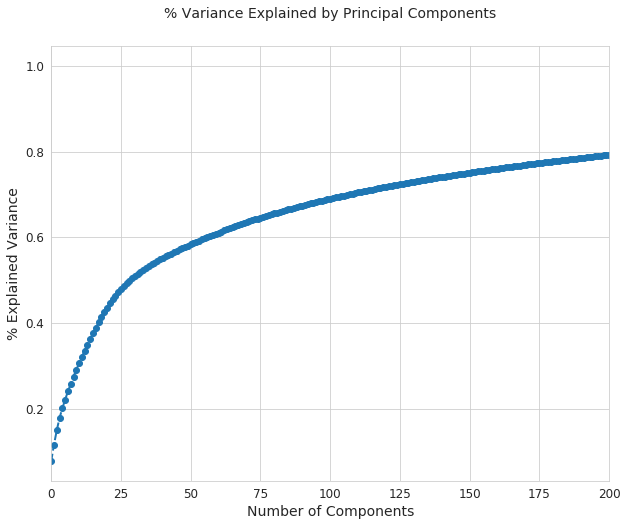

In [92]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [96]:
pca=PCA(n_components=215,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 215 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 215 components is: 0.8017062925111703


In [99]:
X_train=X_pca_21[:28496]
Y_train=fs.iloc[:28496]['Target'].values
X_test=X_pca_21[28496:]
Y_test=fs.iloc[28496:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [100]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,215).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9129000561482313
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22274  2066    24340
True         416  3740     4156
__all__    22690  5806    28496

Accuracy of the model for test data is: 0.9055105215753705
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9488   950    10438
True         204  1571     1775
__all__     9692  2521    12213



Logistic Regression
Accuracy of the model for training data is: 0.9003017967434026
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22179  2161    24340
True         680  3476     4156
__all__    22859  5637    28496

Accuracy of the model for test data is: 0.8974862851060346
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9463   975    10438
True         277  1498     1775
__all__     9740  2473    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9246911847276811
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22371  1969    24340
True         177  3979     4156
__all__    22548  5948    28496

Accuracy of the model for test data is: 0.9104233194137394
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9548   890    10438
True         204  1571     1775
__all__     9752  2461    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.9038110612015722
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22298  2042    24340
True         699  3457     4156
__all__    22997  5499    28496

Accuracy of the model for test data is: 0.9010890035208384
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9520   918    10438
True         290  1485     1775
__all__     9810  2403    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9140581134194273
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22377  1963    24340
True         486  3670     4156
__all__    22863  5633    28496

Accuracy of the model for test data is: 0.9084582002783919
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9548   890    10438
True         228  1547     1775
__all__     9776  2437    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.9273933183604717
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22377  1963    24340
True         106  4050     4156
__all__    22483  6013    28496

Accuracy of the model for test data is: 0.9107508392696307
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9551   887    10438
True         203  1572     1775
__all__     9754  2459    12213



Bagging Classifier
Accuracy of the model for training data is: 0.9251824817518248
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22370  1970    24340
True         162  3994     4156
__all__    22532  5964    28496

Accuracy of the model for test data is: 0.9093588798820929
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9525   913    10438
True         194  1581     1775
__all__     9719  2494    12213



Neural Network-1
The accuracy of the model on training data is: 0.9205151600224593


Predicted  False  True  __all__
Actual                         
False      22232  2108    24340
True         157  3999     4156
__all__    22389  6107    28496

The accuracy of the model on test data is: 0.9042823221157783


Predicted  False  True  __all__
Actual                         
False       9446   992    10438
True         177  1598     1775
__all__     9623  2590    12213

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [101]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [102]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.912900,3740.0,22274.0,2066.0,416.0,0.084881,0.100096
LogisticRegression,0.900302,3476.0,22179.0,2161.0,680.0,0.088784,0.163619
RandomForestClassifier,0.924691,3979.0,22371.0,1969.0,177.0,0.080896,0.042589
AdaBoostClassifier,0.903811,3457.0,22298.0,2042.0,699.0,0.083895,0.168191
GradientBoostingClassifier,0.914058,3670.0,22377.0,1963.0,486.0,0.080649,0.116939
ExtraTreeClassifier,0.927393,4050.0,22377.0,1963.0,106.0,0.080649,0.025505
BaggingClassifier,0.925182,3994.0,22370.0,1970.0,162.0,0.080937,0.038980
Neural Network-1,0.920515,3999.0,22232.0,2108.0,157.0,0.086606,0.037777


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.905511,1571.0,9488.0,950.0,204.0,0.091014,0.114930,0.897028,0.691459
LogisticRegression,0.897486,1498.0,9463.0,975.0,277.0,0.093409,0.156056,0.875267,0.658244
RandomForestClassifier,0.910423,1571.0,9548.0,890.0,204.0,0.085265,0.114930,0.899903,0.702731
AdaBoostClassifier,0.901089,1485.0,9520.0,918.0,290.0,0.087948,0.163380,0.874336,0.663725
GradientBoostingClassifier,0.908458,1547.0,9548.0,890.0,228.0,0.085265,0.128451,0.893142,0.693392
ExtraTreeClassifier,0.910751,1572.0,9551.0,887.0,203.0,0.084978,0.114366,0.900328,0.703693
BaggingClassifier,0.909359,1581.0,9525.0,913.0,194.0,0.087469,0.109296,0.901618,0.702250
Neural Network-1,0.904282,1598.0,9446.0,992.0,177.0,0.095037,0.099718,0.902622,0.694273


In [103]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')